<a href="https://colab.research.google.com/github/masadeghi/lung_cancer_ctscan_survival/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
%%capture
!pip install SimpleITK
!pip install pydicom
!pip install nibabel
!pip install lifelines
!pip uninstall scikit-learn -y
!pip install -U scikit-learn # To update scikit-learn so that it is compatible with scikit-survival
!pip install scikit-survival

# Restart runtime after running this cell

In [1]:
import sys
import os
import requests
import random
import glob
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# download tcia_utils
tcia_utils_text = requests.get("https://github.com/kirbyju/TCIA_Notebooks/raw/main/tcia_utils.py")
with open('tcia_utils.py', 'wb') as f:
    f.write(tcia_utils_text.content)
import tcia_utils as tcia

import pydicom
import SimpleITK as sitk
import nibabel as nib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored

import lifelines
from lifelines import KaplanMeierFitter as KM
from lifelines import AalenAdditiveFitter
from lifelines import CoxPHFitter

# Import data from TCIA

In [2]:
# Shared cart with only the CT scans (without the reconstruct files) of the NSCLC-Radiomics dataset
# Full dataset: https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-56151670240280774

data = tcia.getSharedCart(name = "nbia-56151670240280774")
nsclc_data = tcia.downloadSeries(data, csv_filename = "my_shared_cart")
display(nsclc_data)


# A small sample of 20 to get the code up and running:
# https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-30001670303233978


# Or a sample of 40:
# https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-47941670310489610

# data = tcia.getSharedCart(name = "nbia-47941670310489610")
# nsclc_data = tcia.downloadSeries(data, csv_filename = "my_shared_cart")
# display(nsclc_data)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-56151670240280774
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.32722.99.99.10025153101113104678051738059573807863
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.32722.99.99.100796612659190052505363080760012883208
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.32722.99.99.10189656126533693830027700178890636528
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.32722.99.99.10236962626800300138607005550362876935
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.3272

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Date,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,File Location,Series Number,License Name,License URL,Annotation Size
0,1.3.6.1.4.1.32722.99.99.1002515310111310467805...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-233,1.3.6.1.4.1.32722.99.99.1305991291686280232075...,02-07-2008,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,134,70513418,StudyID,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
1,1.3.6.1.4.1.32722.99.99.1007966126591900525053...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-273,1.3.6.1.4.1.32722.99.99.9466276205070426207560...,07-11-2008,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,136,71563126,StudyID,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
2,1.3.6.1.4.1.32722.99.99.1018965612653369383002...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-217,1.3.6.1.4.1.32722.99.99.3291649604656553669390...,01-23-2008,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,94,49463980,StudyID,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
3,1.3.6.1.4.1.32722.99.99.1023696262680030013860...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-374,1.3.6.1.4.1.32722.99.99.1703221912988594717161...,03-25-2010,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,130,68408250,NaN,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
4,1.3.6.1.4.1.32722.99.99.1024160268794768362699...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-343,1.3.6.1.4.1.32722.99.99.3312361520019439062061...,05-14-2009,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,94,49464960,StudyID,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,1.3.6.1.4.1.32722.99.99.9595829712552318095863...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-415,1.3.6.1.4.1.32722.99.99.2696693784763874516096...,07-04-2010,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,122,64193716,NaN,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
418,1.3.6.1.4.1.32722.99.99.9682167945364966649956...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-150,1.3.6.1.4.1.32722.99.99.1705847099266266731204...,11-17-2006,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,120,63144890,StudyID,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
419,1.3.6.1.4.1.32722.99.99.9716205532865849872709...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-080,1.3.6.1.4.1.32722.99.99.9349453606929886650074...,12-31-2005,SIEMENS,CT,1.2.840.10008.5.1.4.1.1.2,99,52093562,StudyID,0.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
420,1.3.6.1.4.1.32722.99.99.9839559266808469855854...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-045,1.3.6.1.4.1.32722.99.99.2311501642456228508967...,01-01-2014,CMS Inc.,CT,1.2.840.10008.5.1.4.1.1.2,108,56777618,StudyID,1.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0


In [ ]:
# If data already imported:
nsclc_data = pd.read_csv("/content/my_shared_cart.csv", index_col = "Unnamed: 0")

# Convert the folder names of the imported files to their corresponding patient ID

In [3]:
paths = os.listdir("/content/tciaDownload")

for path in paths:
  if "1-001.dcm" in os.listdir(os.path.join("/content/tciaDownload", path)):
    image_path = os.path.join("/content/tciaDownload", path, "1-001.dcm")
  else:
    image_path = os.path.join("/content/tciaDownload", path, "1-01.dcm")
  image = pydicom.dcmread(image_path)
  patient_id = str(image.PatientName)[-3:]
  os.rename(os.path.join("/content/tciaDownload", path), os.path.join("/content/tciaDownload", patient_id))

# Converting DICOM series files into Nifti volumes

In [4]:
patient_folders = os.listdir("/content/tciaDownload")

os.mkdir("/content/nifti_images")

for patient in patient_folders:
  reader = sitk.ImageSeriesReader()
  dicom_names = reader.GetGDCMSeriesFileNames(os.path.join('/content/tciaDownload', patient))
  reader.SetFileNames(dicom_names)
  image = reader.Execute()

  # # A call to PermuteAxes to change the axes of the data
  # image = sitk.PermuteAxes(image, [1,0,2])

  sitk.WriteImage(image, f'/content/nifti_images/patient_{patient}.nii')

In [ ]:
test_image = nib.load("/content/nifti_images/patient_015.nii").get_fdata()

plt.figure(figsize=(8, 8))
plt.imshow(test_image[:, :, 49], cmap = 'gray')

# Preprocessing data

## Helper functions

In [ ]:
def read_nifti_file(filepath):
  scan = nib.load(filepath)
  scan = scan.get_fdata()
  return scan

def normalize(volume):
  min = -1000
  max = 400
  volume[volume < min] = min
  volume[volume > max] = max
  voume = (volume - min) / (max - min)
  volume = volume.astype("float32")
  return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 270, reshape=False)
    img = np.fliplr(img)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

## Divide image data into train-val-test sets

In [7]:
patient_files = os.listdir("/content/nifti_images")
random.seed(42)
random.shuffle(patient_files)

train_patients = patient_files[:int(len(patient_files) * 0.7)]
train_paths = [os.path.join("/content/nifti_images", patient) for patient in train_patients]

val_patients = patient_files[int(len(patient_files) * 0.7):int(len(patient_files) * 0.85)]
val_paths = [os.path.join("/content/nifti_images", patient) for patient in val_patients]

test_patients = patient_files[int(len(patient_files) * 0.85):]
test_paths = [os.path.join("/content/nifti_images", patient) for patient in test_patients]

## Import target survival data

In [23]:
clinical_data = pd.read_csv("/content/NSCLC-Radiomics clinical data.csv", index_col = 0)

clinical_data.head()

,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
PatientID,,,,,,,,,
LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


## Constructing survival curves

In [ ]:
clinical_data["Survival.time"].hist();
plt.xlabel("Observation time before death or censorship (days");
plt.ylabel("Frequencey (number of patients")

In [ ]:
def frac_censored(df):
    """
    Return percent of observations which were censored.
    
    Args:
        df (dataframe): dataframe which contains column 'Event' which is 
                        1 if an event occurred (death)
                        0 if the event did not occur (censored)
    Returns:
        frac_censored (float): fraction of cases which were censored. 
    """
    result = 0.0
    
    censored_count = df["deadstatus.event"] == 0
    result = sum(censored_count)/len(censored_count)
    
    return result

frac_censored(clinical_data)

In [ ]:
clinical_data_censored = clinical_data[clinical_data["deadstatus.event"] == 0]
clinical_data_uncensored = clinical_data[clinical_data["deadstatus.event"] == 1]

clinical_data_censored["Survival.time"].hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

clinical_data["Survival.time"].hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
SI = clinical_data[clinical_data["Overall.Stage"] == 'I']
kmI = KM()
kmI.fit(SI.loc[:, "Survival.time"], event_observed = SI.loc[:, "deadstatus.event"], label = "Stage I")

SII = clinical_data[clinical_data["Overall.Stage"] == 'II']
kmII = KM()
kmII.fit(SII.loc[:, "Survival.time"], event_observed = SII.loc[:, "deadstatus.event"], label = "Stage II")

SIIIa = clinical_data[clinical_data["Overall.Stage"] == 'IIIa']
kmIIIa = KM()
kmIIIa.fit(SIIIa.loc[:, "Survival.time"], event_observed = SIIIa.loc[:, "deadstatus.event"], label = "Stage IIIa")

SIIIb = clinical_data[clinical_data["Overall.Stage"] == 'IIIb']
kmIIIb = KM()
kmIIIb.fit(SIIIb.loc[:, "Survival.time"], event_observed = SIIIb.loc[:, "deadstatus.event"], label = "Stage IIIb")

ax = kmI.plot(ci_show=False)
kmII.plot(ax = ax, ci_show=False)
kmIIIa.plot(ax = ax, ci_show=False)
kmIIIb.plot(ax = ax, ci_show=False)
plt.xlabel('time')
plt.ylabel('Survival probability estimate')
plt.savefig('four_km_curves', dpi=300)

In [ ]:
non_missing_clinical_data = clinical_data.dropna(subset = ["age", "Overall.Stage", "gender"])

aaf = AalenAdditiveFitter()

aaf.fit(non_missing_clinical_data, duration_col = "Survival.time",
        event_col = "deadstatus.event", formula = "Overall.Stage + age + gender")

aaf.cumulative_hazards_.head()

In [ ]:
aaf.plot(columns = ['Overall.Stage[T.II]', "Overall.Stage[T.IIIa]", "Overall.Stage[T.IIIb]"])

In [ ]:
non_missing_clinical_data = clinical_data.dropna(subset = ["age", "Overall.Stage", "gender"])

cph = CoxPHFitter()
cph.fit(non_missing_clinical_data, duration_col = "Survival.time", event_col = "deadstatus.event", formula = "Overall.Stage + age + gender")

cph.print_summary()

## Dividing target variable (survival time) into train-val-test sets

In [24]:
y_train = []
y_val = []
y_test = []

for patient_id in train_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  y_train.append(clinical_data.loc[clincal_data_id, "Survival.time"])
y_train = np.array(y_train)

for patient_id in val_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  y_val.append(clinical_data.loc[clincal_data_id, "Survival.time"])
y_val = np.array(y_val)

for patient_id in test_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  y_test.append(clinical_data.loc[clincal_data_id, "Survival.time"])
y_test = np.array(y_test)

## Dividing event status into train-val-test sets

In [25]:
event_train = []
event_val = []
event_test = []

for patient_id in train_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  event_train.append(clinical_data.loc[clincal_data_id, "deadstatus.event"])
event_train = np.array(event_train)

for patient_id in val_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  event_val.append(clinical_data.loc[clincal_data_id, "deadstatus.event"])
event_val = np.array(event_val)

for patient_id in test_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  event_test.append(clinical_data.loc[clincal_data_id, "deadstatus.event"])
event_test = np.array(event_test)

## Apply normalization and resizing to images

In [15]:
X_train = np.array([process_scan(path) for path in train_paths]) # X_train.shape is [sample size, 128, 128, 64]
X_val = np.array([process_scan(path) for path in val_paths])
X_test = np.array([process_scan(path) for path in test_paths])

## Visualize preprocessed image

Dimension of the CT scan is: (128, 128, 64)


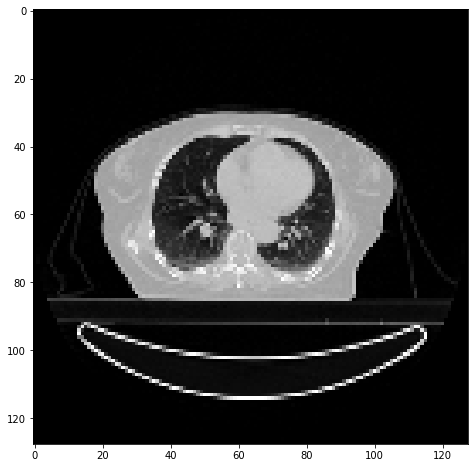

In [16]:
image = X_train[0]
print("Dimension of the CT scan is:", image.shape)
plt.figure(figsize=(8, 8))
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

# Survival analysis using deep learning

## Expand dims for 3d conv net

In [17]:
X_train = X_train[..., np.newaxis] # X_train.shape = [sample_size, 128, 128, 64, 1]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Define class for extracting batches from data and calculating Cox-proportional hazards from batches

In [36]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind = "mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 8,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 42) -> None:
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, d, c = self.images.shape[1:] # Added c
        images = tf.TensorShape([batch_size, h, w, d, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:

        """
        Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

## Define class for calculating Harrell's C-index

In [10]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        result_data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            result_data[k] = v

        return result_data

## Defining model architecture tensorflow graphs


In [11]:
class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset
        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):

        y_event = tf.expand_dims(y_event, axis=1)

        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return train_loss, logits

    def train_and_evaluate(self):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = tf.summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = tf.summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
            if step == 0:
                # see https://stackoverflow.com/questions/58843269/display-graph-using-tensorflow-v2-0-in-tensorboard
                func = self.train_one_step.get_concrete_function(
                    x, y["label_event"], y["label_riskset"])
                tf.summary.graph(func.graph)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 5 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                tf.summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        tf.summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
            tf.summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

In [12]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation='linear')(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3d_cnn_survival_model")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3d_cnn_survival_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                             

## Training the model

In [42]:
train_fn = InputFunction(X_train, y_train, event_train,
                  drop_last=True,
                  shuffle=True)

eval_fn = InputFunction(X_val, y_val, event_val)

trainer = TrainAndEvaluateModel(
    model=model,
    model_dir=Path("3d_cnn_survival_model"),
    train_dataset=train_fn(),
    eval_dataset=eval_fn(),
    learning_rate=0.0001,
    num_epochs=50,
)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir 3d_cnn_survival_model

In [41]:
import shutil

shutil.rmtree("/content/3d_cnn_survival_model")

In [43]:
trainer.train_and_evaluate()

step 0: mean loss = 0.8611
step 5: mean loss = 1.1216
step 10: mean loss = 1.1688
step 15: mean loss = 1.2790
step 20: mean loss = 1.2055
step 25: mean loss = 1.2296
step 30: mean loss = 1.1241
step 35: mean loss = 1.2091
Validation: loss = 1.2709, cindex = 0.5439
step 40: mean loss = 0.9913
step 45: mean loss = 1.1177
step 50: mean loss = 1.0821
step 55: mean loss = 1.1662
step 60: mean loss = 1.1604
step 65: mean loss = 1.0669
step 70: mean loss = 1.1290
Validation: loss = 1.2729, cindex = 0.5236
step 75: mean loss = 0.9460
step 80: mean loss = 0.9825
step 85: mean loss = 1.0365
step 90: mean loss = 1.0814
step 95: mean loss = 1.0788
step 100: mean loss = 0.9520
step 105: mean loss = 0.9906
Validation: loss = 1.2525, cindex = 0.5573
step 110: mean loss = 0.9238
step 115: mean loss = 0.9281
step 120: mean loss = 0.9226
step 125: mean loss = 0.9707
step 130: mean loss = 0.9320
step 135: mean loss = 0.9006
step 140: mean loss = 0.8355
Validation: loss = 1.2609, cindex = 0.5688
step 145:

## Predict survival functions

In [44]:
from sksurv.linear_model.coxph import BreslowEstimator


class Predictor:

    def __init__(self, model, model_dir):
        self.model = model
        self.model_dir = model_dir

    def predict(self, dataset):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=tf.keras.optimizers.Adam(),
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        risk_scores = []
        for batch in dataset:
            pred = self.model(batch, training=False)
            risk_scores.append(pred.numpy())

        return np.row_stack(risk_scores)

In [45]:
train_pred_fn = tf.data.Dataset.from_tensor_slices(X_train).batch(8)

predictor = Predictor(model, trainer.model_dir)
train_predictions = predictor.predict(train_pred_fn)

breslow = BreslowEstimator().fit(train_predictions, event_train, y_train)

Latest checkpoint restored from 3d_cnn_survival_model/ckpt-1.


Latest checkpoint restored from 3d_cnn_survival_model/ckpt-1.


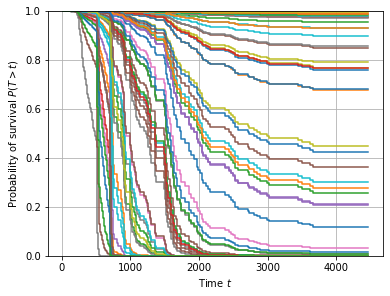

In [46]:
pred_ds = tf.data.Dataset.from_tensor_slices(
    X_test).batch(8)
test_predictions = predictor.predict(pred_ds)

sample_surv_fn = breslow.get_survival_function(test_predictions)

plt.figure(figsize=(6, 4.5))
for surv_fn, class_label in zip(sample_surv_fn, y_test):
    plt.step(surv_fn.x, surv_fn.y, where="post",
             color=f"C{class_label}")

plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()